## Loading the Dataset

In [1]:
import pandas as pd 
import numpy as np 
df1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')

The first dataset contains the following features:-

* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

The second dataset has the following features:- 

* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
* id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average -  average ratings the movie recieved.
* vote_count - the count of votes recieved.

Let's join the two dataset on the 'id' column


In [2]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

In [3]:
df2.head(5)

# **Demographic Filtering** -
   Before getting started with this  -
* we need a metric to score or rate movie 
* Calculate the score for every movie 
* Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes.
So, I'll be using IMDB's weighted rating (wr) which is given as :-

![](https://image.ibb.co/jYWZp9/wr.png)
where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as 

In [4]:
C= df2['vote_average'].mean()
C

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [5]:
m= df2['vote_count'].quantile(0.9)
m

Now, we can filter out the movies that qualify for the chart 

In [6]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

We see that there are 481 movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, **weighted_rating()** and define a new feature **score**, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [7]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [8]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [9]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

Hurray! We have made our first(though very basic) recommender.
Under the **Trending Now** tab of these systems we find movies that are very popular and they can just be obtained by sorting the dataset by the popularity column.

In [10]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


Now something to keep in mind is that these demographic recommender provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user.
This is when we move on to a more refined system-  Content Basesd Filtering. 

# **Content Based Filtering**
In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the **overview** feature of our dataset. 
Let's take a look at the data. .. 

In [11]:
df2['overview'].head(5)

For any of you who has done even a  bit of text processing before knows we need to convert the word vector of each overview. Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as
   **(term instances/total instances)**.
Inverse Document Frequency is the relative count of documents containing the term is given as 
**log(number of documents/documents with term)**
The overall importance of each word to the documents in which they appear is equal to **TF * IDF**

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

In [12]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity). There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
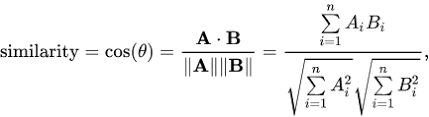

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [26]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [27]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()


We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [28]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [29]:
get_recommendations('The Dark Knight Rises')

In [30]:
get_recommendations('The Avengers')

# **Collaborative Filtering**

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers.
It is basically of two types:-

*  **User based filtering**-  These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity.
This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.
![](https://cdn-images-1.medium.com/max/1000/1*9NBFo4AUQABKfoUOpE3F8Q.png)

Since user A and F do not share any movie ratings in common with user E, their similarities with user E are not defined in Pearson Correlation. Therefore, we only need to consider user B, C, and D. Based on Pearson Correlation, we can compute the following similarity.
![](https://cdn-images-1.medium.com/max/1000/1*jZIMJzKM1hKTFftHfcSxRw.png)

From the above table we can see that user D is very different from user E as the Pearson Correlation between them is negative. He rated Me Before You higher than his rating average, while user E did the opposite. Now, we can start to fill in the blank for the movies that user E has not rated based on other users.
![](https://cdn-images-1.medium.com/max/1000/1*9TC6BrfxYttJwiATFAIFBg.png)

Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

* **Item Based Collaborative Filtering** - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.
![](https://cdn-images-1.medium.com/max/1000/1*LqFnWb-cm92HoMYBL840Ew.png)

It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is ***scalability***. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, ***sparsity*** is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both.



### **Single Value Decomposition**
One way to handle the scalability and sparsity issue created by CF is to leverage a **latent factor model** to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). **The lower the RMSE, the better the performance**.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. 

Now enough said , let's see how to implement this.
Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the [**Surprise** ](https://surprise.readthedocs.io/en/stable/index.html) library to implement SVD.

In [19]:
from surprise import Reader, Dataset, SVD, evaluate
reader = Reader()
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.head()

Note that in this dataset movies are rated on a scale of 5 unlike the earlier one.

In [20]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [21]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

We get a mean Root Mean Sqaure Error of 0.89 approx which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [22]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Let us pick user with user Id 1  and check the ratings she/he has given.

In [23]:
ratings[ratings['userId'] == 1]

In [25]:
svd.predict(1, 302, 3)

For movie with ID 302, we get an estimated prediction of **2.618**. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## **Conclusion** 
We create recommenders using demographic , content- based and collaborative filtering. While demographic filtering is very elemantary and cannot be used practically, **Hybrid Systems** can take advantage of content-based and collaborative filtering as the two approaches are proved to be almost complimentary.
This model was very baseline and only provides a fundamental framework to start with.